# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

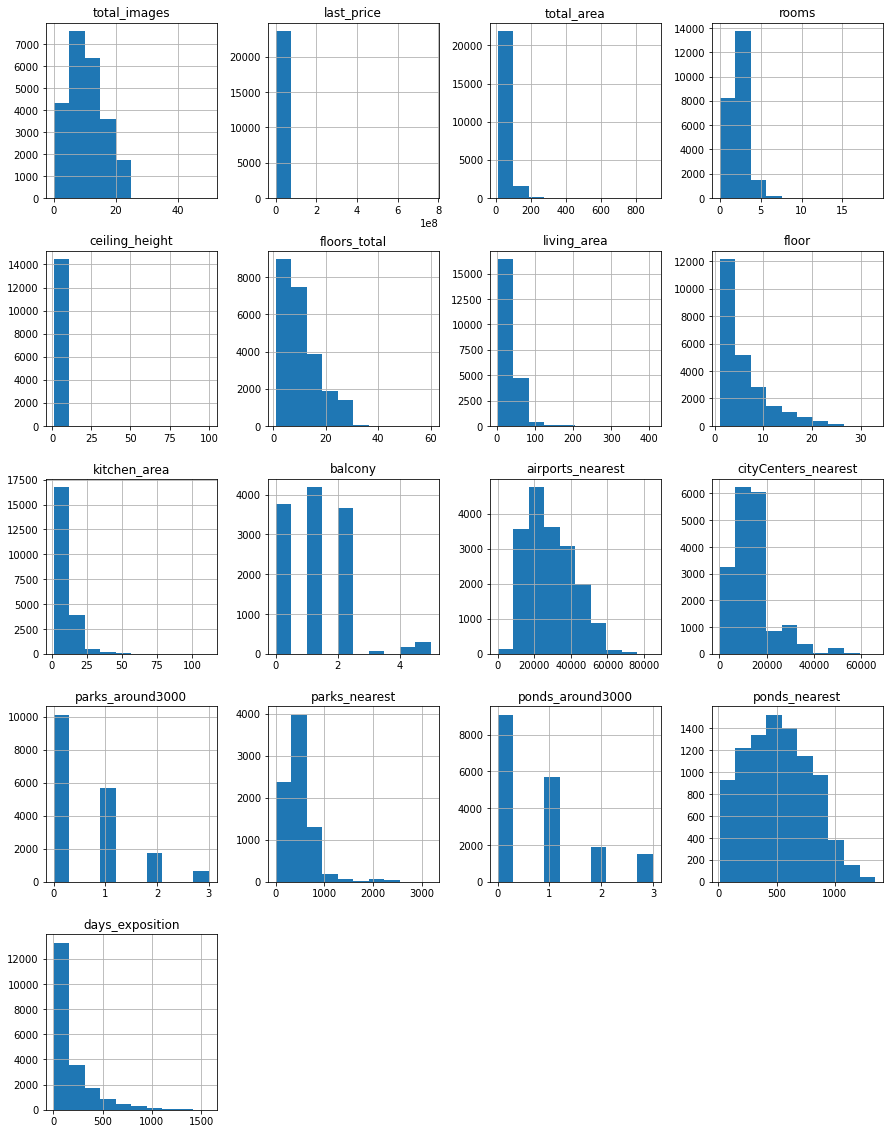

In [ ]:
#Импортируем библиотеку pandas. Считали из csv-файла в датафрейм и сохранили в переменную data.

import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

data.info(20)
data.hist(figsize=(15, 20))
plt.show()

### Выполните предобработку данных

**Начнем предобработку данных и проверим пропущенные значения в данных.**

In [ ]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Заполним пропущенные значения. В некоторых столбцах мы можем заменить значения на 0, предполагая, что отсутствие информации означает отсутствие. Это касается столбцов: floors_total, balcony, parks_around3000, ponds_around3000**

In [ ]:
data['floors_total'] = data['floors_total'].fillna(0)
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

**Удалим пропущенные данные в следующих столбцах: floors_total, locality_name**

In [ ]:
data.dropna(subset=['floors_total', 'locality_name'], inplace=True)

**Заполним пропущенные значения медианой или средним значением: ceiling_height, kitchen_area**

In [ ]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

**Рассмотрим значение в столбец is_apartment поменяем его с формата object на bool, так как значение имеет 3 исхода да, нет и пропущенное. После того, как мы поменяли тип значения is_apartment на булевый, пропущенные значения (NaN) интерпретируются как False. Пропущенные значения теперь равно 0.**

In [ ]:
data['is_apartment'] = data['is_apartment'].replace({'да': True, 'нет': False})
data['is_apartment'] = data['is_apartment'].astype(bool)
data.info(20)
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
dtype: int64

Займемся locality_name,уберем все неявные дубликаты.

In [ ]:
data['locality_name'] = data['locality_name'].str.lower().str.strip()
data['locality_name'] = data['locality_name'].replace({
    'поселок рябово': 'рябово',
    'поселок городского типа рябово': 'рябово',
    'поселок городского типа шушары': 'шушары',
    'посёлок шушары': 'шушары',
    'посёлок мурино': 'мурино',
    'поселок мурино': 'мурино',
    'городской посёлок назия': 'назия',
    'городской посёлок янино-1': 'янино-1',
    'посёлок парголово': 'парголово',
    'поселок парголово': 'парголово',
    'поселок городского типа красный бор': 'красный бор',
    'деревня фёдоровское': 'федоровское',
    'деревня федоровское': 'федоровское',
    'деревня новое девяткино': 'новое девяткино',
    'посёлок металлострой': 'металлострой',
    'поселок металлострой': 'металлострой',
    'посёлок городского типа лебяжье': 'лебяжье',
    'поселок городского типа лебяжье': 'лебяжье',
    'посёлок городского типа сиверский': 'сиверский',
    'поселок городского типа сиверский': 'сиверский',
    'поселок молодцово': 'молодцово',
    'посёлок молодцово': 'молодцово',
    'поселок городского типа кузьмоловский': 'кузьмоловский',
    'посёлок городского типа кузьмоловский': 'кузьмоловский',
    'садовое товарищество новая ропша': 'новая ропша',
    'деревня пикколово': 'пикколово',
    'городской посёлок павлово': 'павлово',
    'поселок города петергоф': 'петергоф',
    'поселок городского типа рощино': 'рощино',
    'посёлок аннино': 'аннино',
    'посёлок плодовое': 'плодовое',
    'поселок торковичи': 'торковичи',
    'поселок первомайское': 'первомайское',
    'красное село': 'красное село',
    'посёлок понтонный': 'понтонный',
    'деревня старая': 'старая',
    'деревня лесколово': 'лесколово',
    'посёлок новый свет': 'новый свет',
    'село путилово': 'путилово',
    'поселок новый свет': 'новый свет',
    'деревня оржицы': 'оржицы',
    'деревня кальтино': 'кальтино',
    'поселок романовка': 'романовка',
    'посёлок бугры': 'бугры',
    'поселок городского типа рощино': 'рощино',
    'село павлово': 'павлово',
    'поселок оредеж': 'оредеж',
    'село копорье': 'копорье',
    'посёлок молодёжное': 'молодежное',
    'посёлок победа': 'победа',
    'деревня нурма': 'нурма',
    'поселок синявино': 'синявино',
    'посёлок стрельна': 'стрельна',
    'посёлок александровская': 'александровская',
    'деревня лопухинка': 'лопухинка',
    'поселок терволово': 'терволово',
    'поселок городского типа советский': 'советский',
    'посёлок петровское': 'петровское',
    'посёлок городского типа токсово': 'токсово',
    'поселок сельцо': 'сельцо',
    'посёлок городского типа вырица': 'вырица',
    'деревня кипень': 'кипень',
    'деревня келози': 'келози',
    'деревня вартемяги': 'вартемяги',
    'посёлок тельмана': 'тельмана',
    'поселок севастьяново': 'севастьяново',
    'городской поселок большая ижора': 'большая ижора',
    'городской посёлок павлово': 'павлово',
    'деревня агалатово': 'агалатово',
    'посёлок новогорелово': 'новогорелово',
    'городской посёлок лесогорский': 'лесогорский',
    'деревня лаголово': 'лаголово',
    'поселок цвелодубово': 'цвелодубово',
    'поселок городского типа ряхья': 'рахья',
    'поселок городского типа вырица': 'вырица',
    'деревня белогорка': 'белогорка',
    'поселок заводской': 'заводской',
    'городской посёлок новоселье': 'новоселье',
    'деревня большие колпаны': 'большие колпаны',
    'деревня горбунки': 'горбунки',
    'деревня батово': 'батово',
    'деревня заневка': 'заневка',
    'деревня иссад': 'иссад',
    'городской посёлок фёдоровское': 'федоровское',
    'деревня мистолово': 'мистолово',
    'поселок зимитицы': 'зимитицы',
    'поселок барышево': 'барышево',
    'деревня разметелево': 'разметелево',
    'поселок городского типа имени свердлова': 'имени свердлова',
    'деревня пеники': 'пеники',
    'деревня пудомяги': 'пудомяги',
    'поселок станции корнево': 'корнево',
    'деревня низино': 'низино',
    'деревня бегуницы': 'бегуницы',
    'посёлок поляны': 'поляны',
    'городской посёлок мга': 'мга',
    'поселок елизаветино': 'елизаветино',
    'посёлок городского типа кузнечное': 'куzneчное',
    'поселок запорожское': 'запорожское',
    'посёлок городского типа рощино': 'рощино',
    'деревня гостилицы': 'гостилицы',
    'деревня малое карлино': 'малое карлино',
    'посёлок мичуринское': 'мичуринское',
    'посёлок городского типа имени морозова': 'имени морозова',
    'посёлок песочный': 'песочный',
    'посёлок сосново': 'сосново',
    'деревня аро': 'аро',
    'поселок ильичёво': 'ильичево',
    'посёлок городского типа тайцы': 'тайцы',
    'деревня малое верево': 'малое верево',
    'деревня извара': 'извара',
    'поселок станции вещево': 'вещево',
    'село паша': 'паша',
    'деревня калитино': 'калитино',
    'посёлок городского типа ульяновка': 'ульяновка',
    'деревня чудской бор': 'чудской бор',
    'поселок городского типа дубровка': 'дубровка',
    'деревня мины': 'мины',
    'поселок войсковицы': 'войсковицы',
    'посёлок городского типа имени свердлова': 'имени свердлова',
    'деревня коркино': 'коркино',
    'посёлок ропша': 'ропша',
    'поселок городского типа приладожский': 'приладожский',
    'посёлок щеглово': 'щеглово',
    'посёлок гаврилово': 'гаврилово',
    'лодейное поле': 'лодейное поле',
    'деревня рабитицы': 'рабитицы',
    'поселок городского типа никольский': 'никольский',
    'деревня кузьмолово': 'кузьмолово',
    'деревня малые колпаны': 'малые колпаны',
    'поселок тельмана': 'тельмана',
    'посёлок петро-славянка': 'петро-славянка',
    'посёлок репино': 'репино',
    'посёлок ильичёво': 'ильичево',
    'поселок углово': 'углово',
    'поселок старая малукса': 'старая малукса',
    'садовое товарищество арас': 'арас',
    'поселок аннино': 'аннино',
    'поселок победа': 'победа',
    'деревня меньково': 'меньково',
    'деревня старые бегуницы': 'старые бегуницы',
    'посёлок сапёрный': 'сапёрный',
    'поселок семрино': 'семрино',
    'поселок гаврилово': 'гаврилово',
    'поселок глажево': 'глажево',
    'поселок кобринское': 'кобринское',
    'деревня гарболово': 'гарболово',
    'деревня юкки': 'юкки',
    'поселок станции приветнинское': 'приветнинское',
    'деревня мануйлово': 'мануйлово',
    'деревня пчева': 'пчева',
    'поселок поляны': 'поляны',
    'поселок цвылёво': 'цвылево',
    'поселок мельниково': 'мельниково',
    'посёлок пудость': 'пудость',
    'посёлок усть-луга': 'усть-луга',
    'поселок селезнёво': 'селезнёво',
    'деревня кривко': 'кривко',
    'поселок глебычево': 'глебычево',
    'деревня парицы': 'парицы',
    'поселок жилпосёлок': 'жилпоселок',
    'посёлок городского типа мга': 'мга',
    'городской поселок янино-1': 'янино-1',
    'посёлок войскорово': 'войскорово',
    'село никольское': 'никольское',
    'посёлок терволово': 'терволово',
    'поселок стеклянный': 'стеклянный',
    'посёлок городского типа важины': 'важины',
    'посёлок мыза-ивановка': 'мыза-ивановка',
    'село русско-высоцкое': 'русско-высоцкое',
    'поселок городского типа форносово': 'форносово',
    'село старая ладога': 'старая ладога',
    'поселок житково': 'житково',
    'городской посёлок виллози': 'виллози',
    'деревня лампово': 'лампово',
    'деревня шпаньково': 'шпаньково',
    'деревня лаврики': 'лаврики',
    'посёлок сумино': 'сумино',
    'посёлок возрождение': 'возрождение',
    'деревня старосиверская': 'старосиверская',
    'посёлок кикерино': 'кикерино',
    'поселок возрождение': 'возрождение',
    'деревня старое хинколово': 'старое хинколово',
    'посёлок пригородный': 'пригородный',
    'посёлок торфяное': 'торфяное',
    'городской посёлок будогощь': 'будогощь',
    'поселок суходолье': 'суходолье',
    'поселок красная долина': 'красная долина',
    'деревня хапо-ое': 'хапо-ое',
    'поселок городского типа дружная горка': 'дружная горка',
    'поселок лисий нос': 'лисий нос',
    'деревня яльгелево': 'яльгелево',
    'посёлок стеклянный': 'стеклянный',
    'село рождествено': 'рождествено',
    'деревня старополье': 'старополье',
    'посёлок левашово': 'левашово',
    'деревня сяськелево': 'сяськелево',
    'деревня камышовка': 'камышовка',
    'садоводческое некоммерческое товарищество лесная поляна': 'лесная поляна',
    'деревня хязельки': 'хязельки',
    'поселок жилгородок': 'жилгородок',
    'посёлок городского типа павлово': 'павлово',
    'деревня ялгино': 'ялгино',
    'поселок новый учхоз': 'новый учхоз',
    'городской посёлок рощино': 'рощино',
    'поселок гончарово': 'гончарово',
    'поселок почап': 'почап',
    'посёлок сапёрное': 'сапёрное',
    'посёлок платформа 69-й километр': 'платформа 69-й километр',
    'поселок каложицы': 'каложицы',
    'деревня фалилеево': 'фалилеево',
    'деревня пельгора': 'пельгора',
    'поселок городского типа лесогорский': 'лесогорский',
    'деревня торошковичи': 'торошковичи',
    'посёлок белоостров': 'белоостров',
    'посёлок алексеевка': 'алексеевка',
    'поселок серебрянский': 'серебрянский',
    'поселок лукаши': 'лукаши',
    'поселок петровское': 'петровское',
    'деревня щеглово': 'щеглово',
    'поселок мичуринское': 'мичуринское',
    'деревня тарасово': 'тарасово',
    'поселок кингисеппский': 'кингисеппский',
    'посёлок при железнодорожной станции вещево': 'вещево',
    'поселок ушаки': 'ушаки',
    'деревня котлы': 'котлы',
    'деревня сижно': 'сижно',
    'деревня торосово': 'торосово',
    'посёлок форт красная горка': 'форт красная горка',
    'поселок городского типа токсово': 'токсово',
    'деревня новолисино': 'новолисино',
    'посёлок станции громово': 'громово',
    'деревня глинка': 'глинка',
    'посёлок мельниково': 'мельниково',
    'поселок городского типа назия': 'назия',
    'деревня старая пустошь': 'старая пустошь',
    'поселок коммунары': 'коммунары',
    'поселок починок': 'починок',
    'посёлок городского типа вознесенье': 'вознесенье',
    'деревня разбегаево': 'разбегаево',
    'посёлок городского типа рябово': 'рябово',
    'поселок гладкое': 'гладкое',
    'посёлок при железнодорожной станции приветнинское': 'приветнинское',
    'поселок тёсово-4': 'тесово-4',
    'посёлок жилгородок': 'жилгородок',
    'деревня бор': 'бор',
    'посёлок коробицыно': 'коробицыно',
    'деревня большая вруда': 'большая вруда',
    'деревня курковицы': 'курковицы',
    'посёлок лисий нос': 'лисий нос',
    'городской посёлок советский': 'советский',
    'посёлок кобралово': 'кобралово',
    'деревня суоранда': 'суоранда',
    'поселок кобралово': 'кобралово',
    'поселок городского типа кондратьево': 'кондратьево',
    'коттеджный поселок счастье': 'счастье',
    'поселок любань': 'любань',
    'деревня реброво': 'реброво',
    'деревня зимитицы': 'зимитицы',
    'деревня тойворово': 'тойворово',
    'поселок семиозерье': 'семиозерье',
    'поселок лесное': 'лесное',
    'поселок совхозный': 'совхозный',
    'поселок усть-луга': 'усть-луга',
    'посёлок ленинское': 'ленинское',
    'посёлок суйда': 'суйда',
    'посёлок городского типа форносово': 'форносово',
    'деревня нижние осельки': 'нижние осельки',
    'посёлок станции свирь': 'свирь',
    'поселок перово': 'перово',
    'поселок гарболово': 'гарболово',
    'село шум': 'шум',
    'поселок котельский': 'котельский',
    'поселок станции лужайка': 'лужайка',
    'деревня большая пустомержа': 'большая пустомержа',
    'поселок красносельское': 'красносельское',
    'деревня вахнова кара': 'вахнова кара',
    'деревня пижма': 'пижма',
    'коттеджный поселок кивеннапа север': 'кивеннапа север',
    'поселок коробицыно': 'коробицыно',
    'поселок ромашки': 'ромашки',
    'посёлок перово': 'перово',
    'деревня каськово': 'каськово',
    'деревня куровицы': 'куровицы',
    'посёлок плоское': 'плоское',
    'поселок сумино': 'сумино',
    'поселок городского типа большая ижора': 'большая ижора',
    'поселок кирпичное': 'кирпичное',
    'деревня ям-тесово': 'ям-тесово',
    'деревня раздолье': 'раздолье',
    'деревня терпилицы': 'терпилицы',
    'посёлок шугозеро': 'шугозеро',
    'деревня ваганово': 'ваганово',
    'поселок пушное': 'пушное',
    'садовое товарищество садко': 'садко',
    'посёлок усть-ижора': 'усть-ижора',
    'деревня выскатка': 'выскатка',
    'городской посёлок свирьстрой': 'свирьстрой',
    'поселок громово': 'громово',
    'деревня кисельня': 'кисельня',
    'посёлок старая малукса': 'старая малукса',
    'деревня трубников бор': 'трубников бор',
    'поселок калитино': 'калитино',
    'посёлок высокоключевой': 'высокоключевой',
    'садовое товарищество приладожский': 'приладожский',
    'посёлок пансионат зелёный бор': 'пансионат зеленый бор',
    'деревня ненимяки': 'ненимяки',
    'поселок пансионат зелёный бор': 'пансионат зеленый бор',
    'деревня снегирёвка': 'снегиревка',
    'деревня рапполово': 'рапполово',
    'деревня пустынка': 'пустынка',
    'поселок рабитицы': 'рабитицы',
    'деревня большой сабск': 'большой сабск',
    'деревня русско': 'русско',
    'деревня лупполово': 'лупполово',
    'деревня большое рейзино': 'большое рейзино',
    'деревня малая романовка': 'малая романовка',
    'поселок дружноселье': 'дружноселье',
    'поселок пчевжа': 'пчевжа',
    'поселок володарское': 'володарское',
    'деревня нижняя': 'нижняя',
    'коттеджный посёлок лесное': 'лесное',
    'деревня тихковицы': 'тихковицы',
    'деревня борисова грива': 'борисова грива',
    'посёлок дзержинского': 'дзержинского',
    'деревня кудрово': 'кудрово',
    'поселок городского типа ефимовский' : 'ефимовский',
    'деревня куттузи' : 'куттузи',
    'деревня заклинье' : 'заклинье',
    'посёлок городского типа красный бор' : 'красный бор',
    'поселок городского типа синявино' : 'синявино',
    'поселок городского типа рахья' : 'рахья',
    'куzneчное' : 'кузнeчное',
    'садовое товарищество рахья' : 'рахья'


})

data['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'федоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное село', 'понтонный',
       'сясьстрой', 'старая', 'лесколово', 'новый свет', 'сланцы',
       'путилово', 'ивангород', 'шлиссельбург', 'никольское',
       'зеленогорск', 'сосновый бор', 'оржицы', 'кальтино', 'романовка',
       'бугры', 'поселок бугры', 'рощино', 'кириши', 'луга', 'волосово',
       'отрадное', 'павлово', 'оредеж', 'копорье', 'молодежное', 'тихвин',
       'победа', 'нурма', 'синявино', 'тосно', 'стрельна'

In [ ]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Остались несколько колонок (living_area, airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest, days_exposition) с многочисленными пропущенными значениями. Мы их пока не будем трогать.
living_area - критический параметр при поиске квартиры. На данном этапе считаю неправильным вставлять медиальные или средние значения.
airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest - содержат так же достаточное количество пропусков. Удаление подобного количества строк приведет к потери большого количества данных **

Дальше нам необходимо обработатьвыбивающиеся значения (аномалии). Для этого подробно рассмотрим такие столбцы, как:
 last_price, total_area,  living_area, kitchen_area, ceiling_height, rooms, floor и floors_total, airports_nearest и cityCenters_nearest, days_exposition - перенесем их в 4 часть


In [ ]:
data['balcony'] = data['balcony'].astype('Int64')
print(data['balcony'].dtype)
print(data['balcony'].unique())

Int64
<IntegerArray>
[0, 2, 1, 5, 4, 3]
Length: 6, dtype: Int64


Рассмотрели параметр balcony, поменяли ему тип на 'Int64', так как правда, 1.5 балкона быть не может. У нас такие значения не встречаются, но лучше поменять.

In [ ]:
#проверим наличие явлных дубликатов
data.duplicated().sum()


0

Явных дубликатов не обнаружено

<div class="alert alert-info"> <b>сделала проверку явных дубликатов, не было обнаружено, возможно из-за того, что я уже взаимодействовала с данными</b> </div>

### Добавьте в таблицу новые столбцы

Цена одного квадратного метра

In [ ]:
data['price_per_sqm'] = (data['last_price'] / data['total_area']).round(2)

День недели публикации объявления (0 — понедельник, 1 — вторник и т.д.)

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['weekday'] = data['first_day_exposition'].dt.weekday


Месяц публикации объявления, Год публикации объявления

In [ ]:
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data['weekday_name'] = data['first_day_exposition'].dt.day_name()


Тип этажа квартиры (первый, последний, другой)

In [ ]:
data['floor_type'] = 'другой'
data.loc[data['floor'] == 1, 'floor_type'] = 'первый'
data.loc[data['floor'] == data['floors_total'], 'floor_type'] = 'последний'

Расстояние до центра города в километрах (округлено до целого)

In [ ]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()

Проверка новых столбцов

In [ ]:
data[['price_per_sqm', 'weekday_name', 'month', 'year', 'floor_type', 'cityCenters_nearest_km']].head()

,price_per_sqm,weekday_name,month,year,floor_type,cityCenters_nearest_km
0,120370.37,Thursday,3,2019,другой,16.0
1,82920.79,Tuesday,12,2018,первый,19.0
2,92785.71,Thursday,8,2015,другой,14.0
3,408176.10,Friday,7,2015,другой,7.0
4,100000.00,Tuesday,6,2018,другой,8.0


In [ ]:
data.isnull().sum()

total_images                  0
last_price                    0
total_area                    0
first_day_exposition          0
rooms                         0
ceiling_height                0
floors_total                  0
living_area                1898
floor                         0
is_apartment                  0
studio                        0
open_plan                     0
kitchen_area                  0
balcony                       0
locality_name                 0
airports_nearest           5534
cityCenters_nearest        5511
parks_around3000              0
parks_nearest             15586
ponds_around3000              0
ponds_nearest             14565
days_exposition            3180
price_per_sqm                 0
weekday                       0
month                         0
year                          0
weekday_name                  0
floor_type                    0
cityCenters_nearest_km     5511
dtype: int64

### Проведите исследовательский анализ данных

***Для начала рассмотрим 'total_area' ***
Изменим наплавление для boxplot, чтобы было удобнее выводить

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


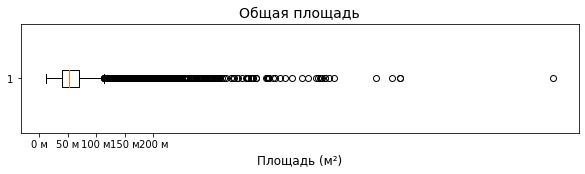

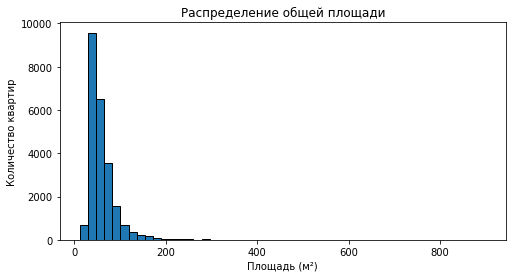

Нижняя граница: -4.550000000000004
Верхняя граница: 114.25


In [ ]:
print(data['total_area'].describe())

#построем Boxplot, который покажем распределение и выбросы


plt.figure(figsize=(10, 2))
plt.boxplot(data['total_area'].dropna(), vert=False)

# Добавляем подписи
plt.title('Общая площадь', fontsize=14)  # Заголовок
plt.xlabel('Площадь (м²)', fontsize=12)  # Подпись оси X

# Добавляем метки на ось X
plt.xticks([0, 50, 100, 150, 200], ['0 м', '50 м', '100 м', '150 м', '200 м'])

# Показать график
plt.show()


plt.figure(figsize=(8, 4))
plt.hist(data['total_area'].dropna(), bins=50, edgecolor='black')
plt.title('Распределение общей площади')
plt.xlabel('Площадь (м²)')
plt.ylabel('Количество квартир')
plt.show()

Q1 = data['total_area'].quantile(0.25)  # 25-й процентиль
Q3 = data['total_area'].quantile(0.75)  # 75-й процентиль
IQR = Q3 - Q1  # Межквартильный размах

# Определяем границы нормальных значений - увеличим допустимый интервал
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Нижняя граница: {lower_bound}")
print(f"Верхняя граница: {upper_bound}")



График больше распространяется справа, это значит, что присутствуют большие площади.
Основная масса квартир имеет площадь до 50 м2, что видно по графику распределния общей площади. Большие квартиры с площадью более 114.25 м2 квартиры будем считать выбросами.


Количество объектов после удаления выбросов: 22406


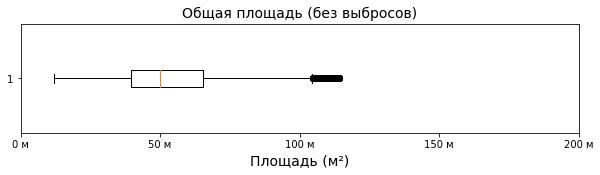

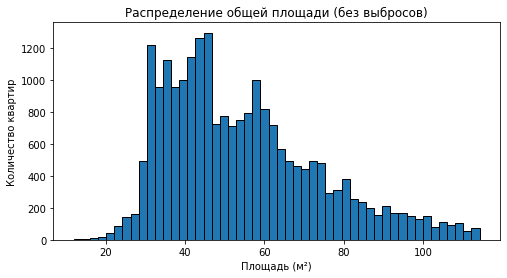

In [ ]:
cl_total_area = data[(data['total_area'] >= lower_bound) & (data['total_area'] <= upper_bound)]
print(f"Количество объектов после удаления выбросов: {len(cl_total_area)}")

# Шаг 3: Построим Boxplot после удаления выбросов
plt.figure(figsize=(10, 2))
plt.boxplot(cl_total_area['total_area'].dropna(), vert=False)

# Добавляем подписи
plt.title('Общая площадь (без выбросов)', fontsize=14)  # Заголовок
plt.xlabel('Площадь (м²)', fontsize=14)  # Подпись оси X
plt.xticks([0, 50, 100, 150, 200], ['0 м', '50 м', '100 м', '150 м', '200 м'])

# Показать график
plt.show()

# Гистограмма после удаления выбросов
plt.figure(figsize=(8, 4))
plt.hist(cl_total_area['total_area'].dropna(), bins=50, edgecolor='black')
plt.title('Распределение общей площади (без выбросов)')
plt.xlabel('Площадь (м²)')
plt.ylabel('Количество квартир')
plt.show()

После удаления выбросов количество объектов состааило 22406.
Можно сказать, что график имеет ассиметрию вправо. Наибольшее количество квартир приходится на площадь 30- 50 м2.Большинство квартир имеют площадь до 100м2.

***Рассмотрим следующие данные 'living_area'***

count    21752.000000
mean        34.448356
std         22.037664
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64


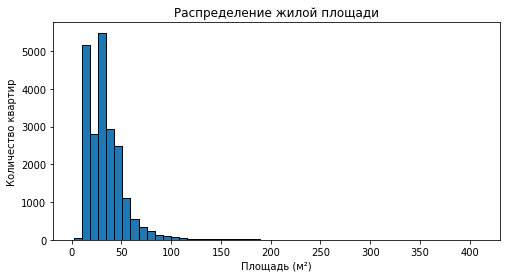

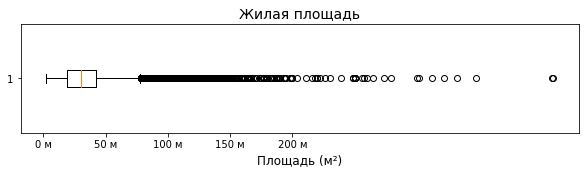

Нижняя граница: -16.949999999999996
Верхняя граница: 77.85


In [ ]:
print(data['living_area'].describe())

plt.figure(figsize=(8, 4))
plt.hist(data['living_area'].dropna(), bins=50, edgecolor='black')
plt.title('Распределение жилой площади')
plt.xlabel('Площадь (м²)')
plt.ylabel('Количество квартир')
plt.show()

# Boxplot жилой площади
plt.figure(figsize=(10, 2))
plt.boxplot(data['living_area'].dropna(), vert=False)

# Подписи
plt.title('Жилая площадь', fontsize=14)
plt.xlabel('Площадь (м²)', fontsize=12)
plt.xticks([0, 50, 100, 150, 200], ['0 м', '50 м', '100 м', '150 м', '200 м'])
plt.show()

Q1 = data['living_area'].quantile(0.25)  # 25-й процентиль
Q3 = data['living_area'].quantile(0.75)  # 75-й процентиль
IQR = Q3 - Q1  # Межквартильный размах

# Границы нормальных значений
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Нижняя граница: {lower_bound}")
print(f"Верхняя граница: {upper_bound}")

Основная масса данных сосредоточено на жилой площади до 45 м2. Значения свыше 77.85 м2 будем считать выбросами.

Количество объектов после удаления выбросов: 20980


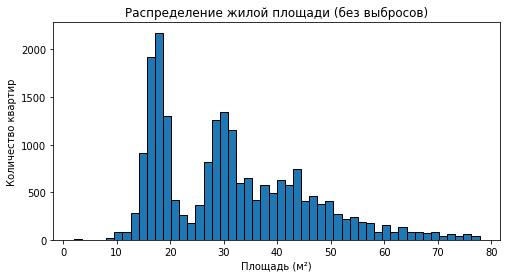

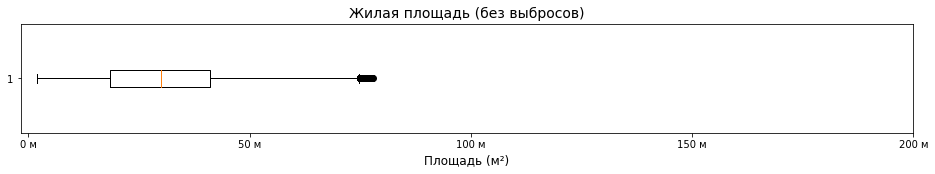

In [ ]:
cl_living_area = data[(data['living_area'] >= lower_bound) & (data['living_area'] <= upper_bound)]
print(f"Количество объектов после удаления выбросов: {len(cl_living_area)}")


# Гистограмма после удаления выбросов
plt.figure(figsize=(8, 4))
plt.hist(cl_living_area['living_area'].dropna(), bins=50, edgecolor='black')
plt.title('Распределение жилой площади (без выбросов)')
plt.xlabel('Площадь (м²)')
plt.ylabel('Количество квартир')
plt.show()

# Boxplot после удаления выбросов
plt.figure(figsize=(16, 2))
plt.boxplot(cl_living_area['living_area'].dropna(), vert=False)

# Подписи
plt.title('Жилая площадь (без выбросов)', fontsize=14)
plt.xlabel('Площадь (м²)', fontsize=12)
plt.xticks([0, 50, 100, 150, 200], ['0 м', '50 м', '100 м', '150 м', '200 м'])
plt.show()


На графике "Распределение жилой площади (без фильтров) " можно отметить 2 пика с повышенным количеством квартир. первый пик площади от 15 до 20 м2, второй с метражом 25 - 32 м2. После площади в 45 м2. можно отметить спад. Квартиры с жилой площадью больше 80 м2 встречаются значительно реже.

***Рассмотрим следующие данные 'kitchen_area'***

In [ ]:
print(data['kitchen_area'].describe())

count    23650.000000
mean        10.425715
std          5.628088
min          1.300000
25%          7.300000
50%          9.100000
75%         11.427500
max        112.000000
Name: kitchen_area, dtype: float64


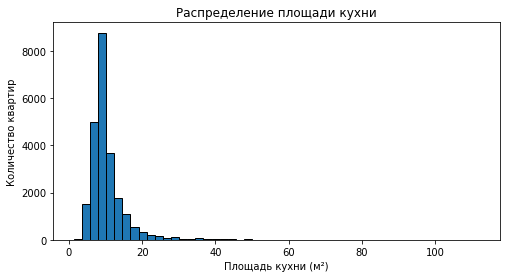

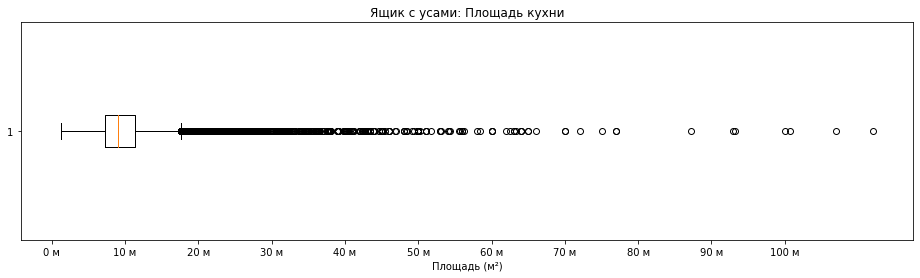

Нижняя граница: 1.1087499999999997
Верхняя граница: 17.61875


In [ ]:
# Гистограмма
plt.figure(figsize=(8, 4))
plt.hist(data['kitchen_area'].dropna(), bins=50, edgecolor='black')
plt.title('Распределение площади кухни')
plt.xlabel('Площадь кухни (м²)')
plt.ylabel('Количество квартир')
plt.show()

# Boxplot
plt.figure(figsize=(16, 4))
plt.boxplot(data['kitchen_area'].dropna(), vert=False)
plt.title('Ящик с усами: Площадь кухни')
plt.xlabel('Площадь (м²)')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], [f'{i} м' for i in range(0, 110, 10)])
plt.show()


Q1 = data['kitchen_area'].quantile(0.25)
Q3 = data['kitchen_area'].quantile(0.75)
IQR = Q3 - Q1

# Границы без выбросов
lower_bound =  Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Нижняя граница: {lower_bound}")
print(f"Верхняя граница: {upper_bound}")

Количество объектов после удаления выбросов: 22102


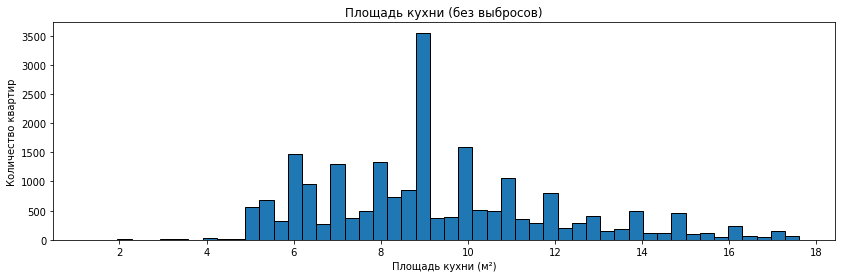

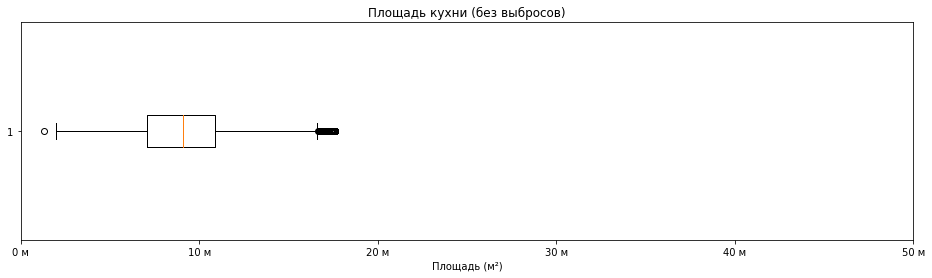

In [ ]:
cl_kitchen_area = data[(data['kitchen_area'] >= lower_bound) & (data['kitchen_area'] <= upper_bound)]
print(f"Количество объектов после удаления выбросов: {len(cl_kitchen_area)}")

plt.figure(figsize=(14, 4))
plt.hist(cl_kitchen_area['kitchen_area'].dropna(), bins=50, edgecolor='black')
plt.title('Площадь кухни (без выбросов)')
plt.xlabel('Площадь кухни (м²)')
plt.ylabel('Количество квартир')
plt.show()

# Boxplot после удаления выбросов
plt.figure(figsize=(16, 4))
plt.boxplot(cl_kitchen_area['kitchen_area'].dropna(), vert=False)
plt.title('Площадь кухни (без выбросов)')
plt.xlabel('Площадь (м²)')
plt.xticks([0, 10, 20, 30, 40, 50], [f'{i} м' for i in range(0, 60, 10)])
plt.show()

 большое количество значений получилось в диапазоне от 6 до 10 м2. Есть выброс и в правую, и в левую сторону, что может говорить о большом количестве студий с имеющимся кухонным уголком. Все выбросы были удалены. Итоговое количество объектов составило 22102.

***Рассмотрим следующие данные 'last_price'***

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64


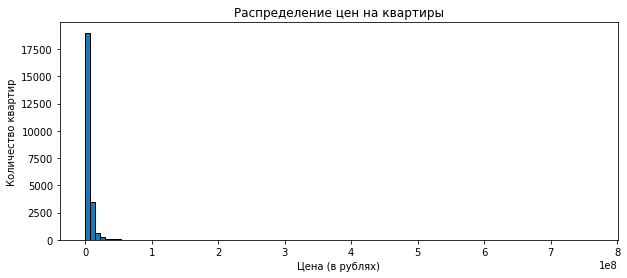

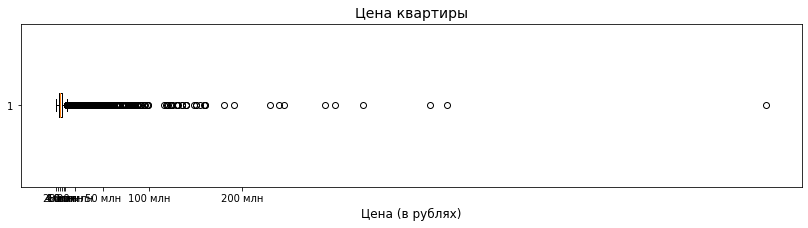

Нижняя граница: -1,698,500 руб.
Верхняя граница: 11,897,500 руб.


In [ ]:
print(data['last_price'].describe())

# Гистограмма цен
plt.figure(figsize=(10, 4))
plt.hist(data['last_price'].dropna(), bins=100, edgecolor='black')
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена (в рублях)')
plt.ylabel('Количество квартир')
plt.show()

# Boxplot (ящик с усами)
plt.figure(figsize=(14, 3))
plt.boxplot(data['last_price'].dropna(), vert=False)

plt.title('Цена квартиры', fontsize=14)
plt.xlabel('Цена (в рублях)', fontsize=12)
plt.xticks([0, 2e6, 4e6, 6e6, 8e6, 10e6, 20e6, 50e6, 100e6, 200e6],
           ['0', '2 млн', '4 млн', '6 млн', '8 млн', '10 млн', '20 млн', '50 млн', '100 млн', '200 млн'])
plt.show()

Q1 = data['last_price'].quantile(0.25)
Q3 = data['last_price'].quantile(0.75)
IQR = Q3 - Q1

# Границы нормальных значений
lower_bound =  Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Нижняя граница: {lower_bound:,.0f} руб.")
print(f"Верхняя граница: {upper_bound:,.0f} руб.")

удалим выбросы, чтобы график и боксплот стали более читаемыми. БОльшинство квартир находятся в левой части до 10 млн. рублей. Правый хвост говорит о наличии дорогой недвижимости. Мы не обращаем внимание, что нижняя граница уходит в отрицательное значение, так как такого не может быть. Условно мы подразумеваем, что нижняя граница равна 0.Можно отметить, что максимальная цена составляет 763 000 000, что является явным выбросом(или элитной недвижимостью)


Количество объявлений после удаления выбросов: 21595


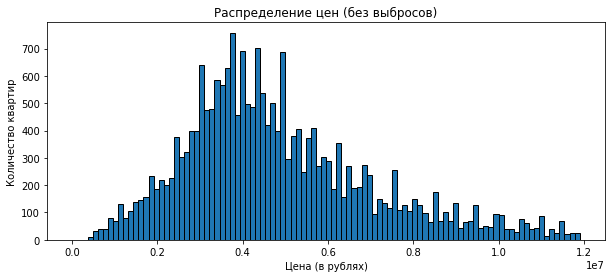

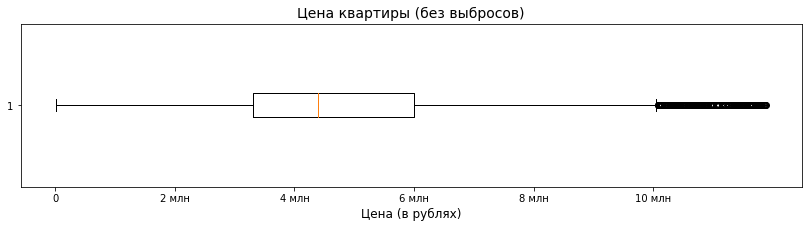

In [ ]:
cl_last_price = data[(data['last_price'] >= lower_bound) & (data['last_price'] <= upper_bound)]
print(f"Количество объявлений после удаления выбросов: {len(cl_last_price)}")

# Гистограмма цены после удаления выбросов
plt.figure(figsize=(10, 4))
plt.hist(cl_last_price['last_price'].dropna(), bins=100, edgecolor='black')
plt.title('Распределение цен (без выбросов)')
plt.xlabel('Цена (в рублях)')
plt.ylabel('Количество квартир')
plt.show()

# Boxplot после удаления выбросов
plt.figure(figsize=(14, 3))
plt.boxplot(cl_last_price['last_price'].dropna(), vert=False)
plt.title('Цена квартиры (без выбросов)', fontsize=14)
plt.xlabel('Цена (в рублях)', fontsize=12)
plt.xticks([0, 2e6, 4e6, 6e6, 8e6, 10e6],
           ['0', '2 млн', '4 млн', '6 млн', '8 млн', '10 млн'])
plt.show()

Количество объявлений после удаления выбросов: 21595


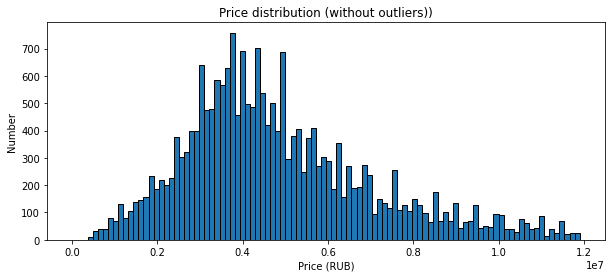

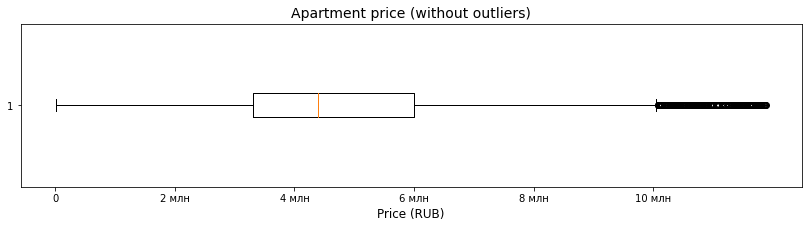

In [ ]:
cl_last_price = data[(data['last_price'] >= lower_bound) & (data['last_price'] <= upper_bound)]
print(f"Количество объявлений после удаления выбросов: {len(cl_last_price)}")

# Гистограмма цены после удаления выбросов
plt.figure(figsize=(10, 4))
plt.hist(cl_last_price['last_price'].dropna(), bins=100, edgecolor='black')
plt.title('Price distribution (without outliers))')
plt.xlabel('Price (RUB)')
plt.ylabel('Number')
plt.show()

# Boxplot после удаления выбросов
plt.figure(figsize=(14, 3))
plt.boxplot(cl_last_price['last_price'].dropna(), vert=False)
plt.title('Apartment price (without outliers)', fontsize=14)
plt.xlabel('Price (RUB)', fontsize=12)
plt.xticks([0, 2e6, 4e6, 6e6, 8e6, 10e6],
           ['0', '2 млн', '4 млн', '6 млн', '8 млн', '10 млн'])
plt.show()

Обычная цена квартиры по медиане составила 3.5 - 5 млн. Разброс основной выборки по ценам на квартиры составил с 3.6 до 6 млн. Цена квартир доходит до 10 млн. Но это значение еще не считается выбросом. БОльшинство квартир находятся в среднем ценовом диапазоне.Распределение цен имеет асимметрию вправо — это означает, что на рынке присутствуют более дорогие квартиры, но их меньше. Что в свою очередь больше отражает картину рынка.

***Рассмотрим следующие данные 'room'***

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


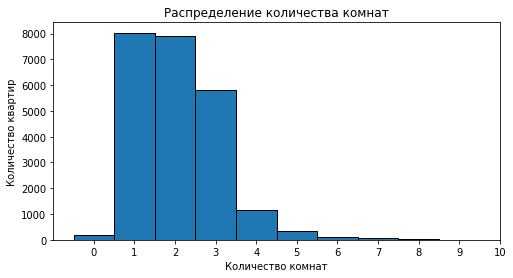

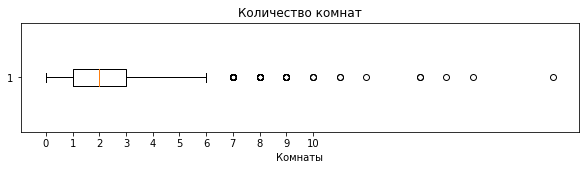

In [ ]:
print(data['rooms'].describe())

# Гистограмма количества комнат
plt.figure(figsize=(8, 4))
plt.hist(data['rooms'].dropna(), bins=range(0, 11), align='left', edgecolor='black')
plt.title('Распределение количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.xticks(range(0, 11))
plt.show()

# Boxplot
plt.figure(figsize=(10, 2))
plt.boxplot(data['rooms'].dropna(), vert=False)
plt.title('Количество комнат')
plt.xlabel('Комнаты')
plt.xticks(range(0, 11))
plt.show()




Максимальное значение составляет 19 комнат, что мы примем за выброс, так как остальное распреление находится в пределах квантиля с показателем 3. Медиана находится на 2.

Количество квартир после фильтрации: 23363


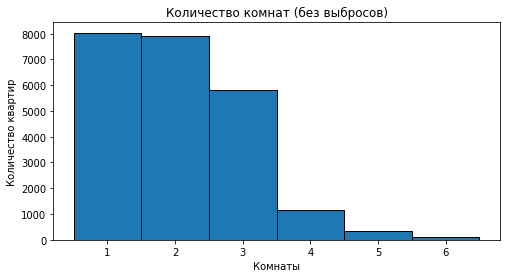

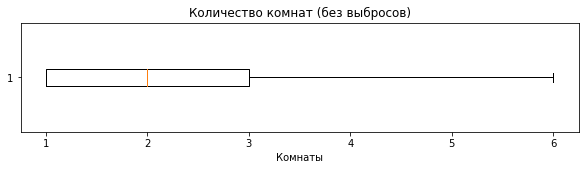

0      197
1     8036
2     7924
3     5797
4     1175
5      326
6      105
7       59
8       12
9        8
10       3
11       2
12       1
14       2
15       1
16       1
19       1
Name: rooms, dtype: int64


In [ ]:
cl_rooms = data[(data['rooms'] >= 1) & (data['rooms'] <= 6)]
print(f"Количество квартир после фильтрации: {len(cl_rooms)}")

# Гистограмма после фильтрации
plt.figure(figsize=(8, 4))
plt.hist(cl_rooms['rooms'].dropna(), bins=range(1, 8), align='left', edgecolor='black')
plt.title('Количество комнат (без выбросов)')
plt.xlabel('Комнаты')
plt.ylabel('Количество квартир')
plt.xticks(range(1, 7))
plt.show()

# Boxplot после фильтрации
plt.figure(figsize=(10, 2))
plt.boxplot(cl_rooms['rooms'].dropna(), vert=False)
plt.title('Количество комнат (без выбросов)')
plt.xlabel('Комнаты')
plt.xticks(range(1, 7))
plt.show()

#произведем анализ для того, чтобы посмотреть есть ли количество комнат 0.
room_counts = data['rooms'].value_counts().sort_index()
print(room_counts)

Есть 197 квартир с показателем комнат 0 - это может говорить о том, что это - квартиры-студии. Медиальное значение составляет 2 компаны. Меквартальный размах составляет от 1 до 3 комнат, что говорит о наиболее популярном количестве комнат. Распределение скошено вправо.

***Рассмотрим следующие данные 'ceiling_height'***

[1.0, 1.2, 1.75, 2.0, 2.2, 2.25, 2.26, 2.3, 2.34, 2.4, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.0, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2, 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3, 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6, 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7, 3.75, 3.76, 3.78, 3.8, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9, 3.93, 3.95, 3.98, 4.0, 4.06, 4.1, 4.14, 4.15, 4.19, 4.2, 4.25, 4.3, 4.37, 4.4, 4.45, 4.5, 4.65, 4.7, 4.8, 4.9, 5.0, 5.2, 5.3, 5.5, 5.6, 5.8, 6.0, 8.0, 8.3, 

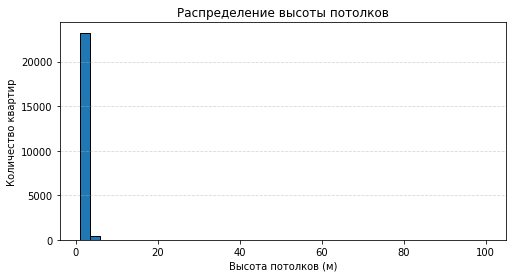

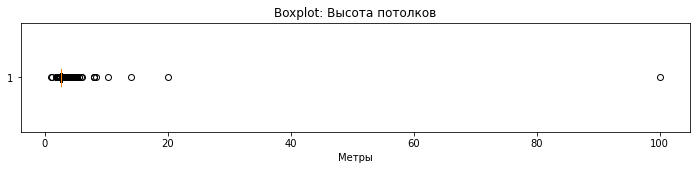

Нижняя граница: 2.45
Верхняя граница: 2.8500000000000005


In [ ]:
#откорректируем данные перед тем как выводить их на экран. Исправим опечатки

data['ceiling_height'] = data['ceiling_height'].replace({
    22.6: 2.26,
    24.0: 2.40,
    25: 2.5,
    26: 2.60,
    27: 2.70,
    27.5: 2.75,
    30: 3.0,
    32: 3.2,
    33: 3.3
})

#выведем на экран список всех значений, чтобы посмотреть ушли ли ошибки.
print(sorted(data['ceiling_height'].dropna().unique()))

print(data['ceiling_height'].describe())

plt.figure(figsize=(8, 4))
plt.hist(data['ceiling_height'].dropna(), bins=40, edgecolor='black')  # 40 узких столбиков
plt.title('Распределение высоты потолков')
plt.xlabel('Высота потолков (м)')
plt.ylabel('Количество квартир')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(12, 2))  # Сделаем график шире
plt.boxplot(data['ceiling_height'].dropna(), vert=False)
plt.title('Boxplot: Высота потолков')
plt.xlabel('Метры')
plt.show()


Q1 = data['ceiling_height'].quantile(0.25)
Q3 = data['ceiling_height'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

Мы сделали корректировку опечаток и поставили ее перед запросом графиков. Вид графика немного изменился. удалим выбросы как слева, так и справа.

Осталось строк после удаления верхних выбросов: 20717


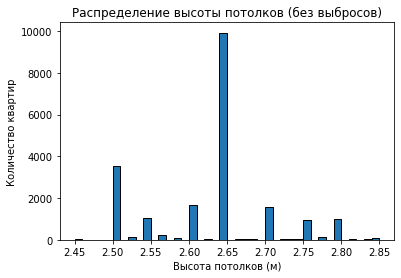

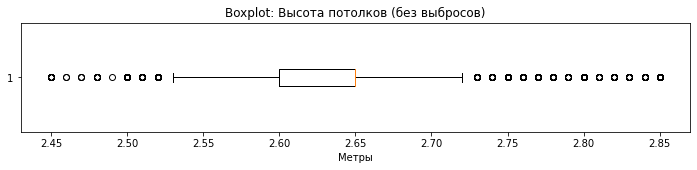

In [ ]:
cl_ceiling_height = data[
    (data['ceiling_height'] >= lower_bound) &
    (data['ceiling_height'] <= upper_bound)
]
print(f"Осталось строк после удаления верхних выбросов: {len(cl_ceiling_height)}")

# Гистограмма
plt.hist(cl_ceiling_height['ceiling_height'].dropna(), bins=40, edgecolor='black')
plt.title('Распределение высоты потолков (без выбросов)')
plt.xlabel('Высота потолков (м)')
plt.ylabel('Количество квартир')
plt.show()

plt.figure(figsize=(12, 2))
plt.boxplot(cl_ceiling_height['ceiling_height'].dropna(), vert=False)
plt.title('Boxplot: Высота потолков (без выбросов)')
plt.xlabel('Метры')
plt.show()

Основные значения находятся в диапазоне от 2.5 где-то до 3 метров, также много квартир с высотой потолкой 2.5 метров. После удаления диаграммы стали более читабельнымию Нижние значения мы оставили. Распределение получилось ассиметрично влево.

***Рассмотрим следующие данные 'floor_type'***

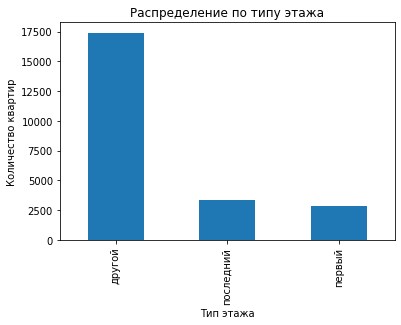

In [ ]:
data['floor_type'].value_counts().plot(kind='bar')
plt.title('Распределение по типу этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Количество квартир')
plt.show()



Можно отметить, что большая часть квартир находится не на первом и не на последнем этаже, называется параметр другой. Количество квартир по данному параметру значительно превышает 2 другие группы. Следует также отметить, что по показателю последний и первый этаж, количество квартир схожее.

***Рассмотрим следующие данные 'floor'***

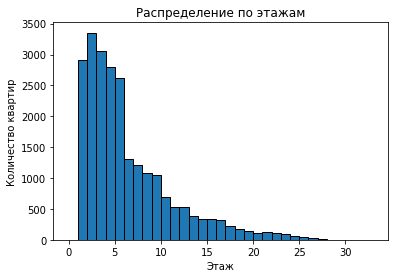

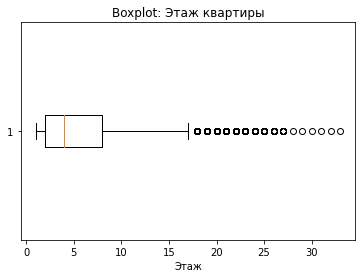

Верхняя граница: 17.0


In [ ]:
plt.hist(data['floor'].dropna(), bins=range(0, data['floor'].max() + 1), edgecolor='black')
plt.title('Распределение по этажам')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()


plt.boxplot(data['floor'].dropna(), vert=False)
plt.title('Boxplot: Этаж квартиры')
plt.xlabel('Этаж')
plt.show()

Q1 = data['floor'].quantile(0.25)
Q3 = data['floor'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print(f'Верхняя граница: {upper_bound}')

Из распределения следует отметить, что большая часть квартир находится на этажах от 3 до 9. Правые значения содержат достаточное количество выбросов. Либо это ошибки, либо новостройки, которые содержат большое количество этажей.

Осталось строк после удаления высоких этажей: 22732


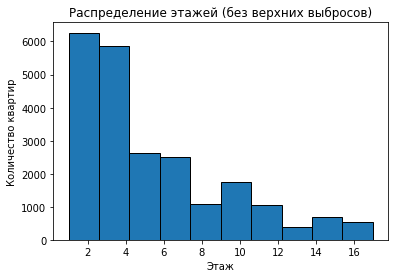

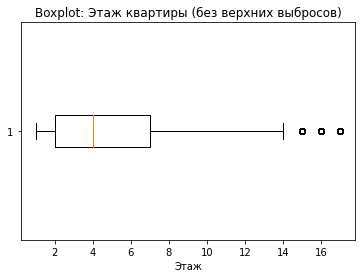

In [ ]:
cl_floor = data[data['floor'] <= upper_bound]

print(f"Осталось строк после удаления высоких этажей: {len(cl_floor)}")

plt.hist(cl_floor['floor'].dropna(), edgecolor='black')
plt.title('Распределение этажей (без верхних выбросов)')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()

plt.boxplot(cl_floor['floor'].dropna(), vert=False)
plt.title('Boxplot: Этаж квартиры (без верхних выбросов)')
plt.xlabel('Этаж')
plt.show()

По результатам анализа следует отметить, что основная часть квартир находится на 3-7 этаже. Справа мы удалили большое количество выбросов. Медиана ближе к границе коробки, однако распределение неравномерное, больше квартир на нижних этажах, чем на верхних

***Рассмотрим следующие данные 'cityCenters_nearest'***

count    18139.000000
mean     14197.860742
std       8606.830295
min        181.000000
25%       9241.000000
50%      13105.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


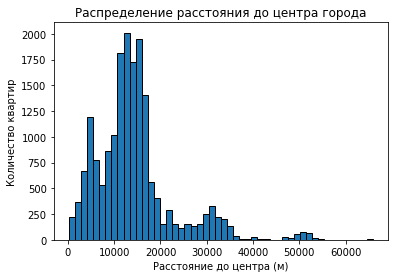

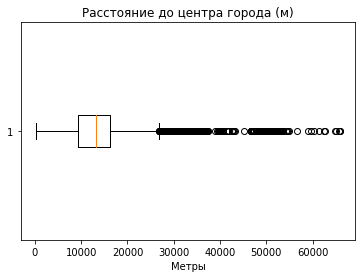

Верхняя граница: 26871.0 метров


In [ ]:
print(data['cityCenters_nearest'].describe())

# Гистограмма
plt.hist(data['cityCenters_nearest'].dropna(), bins=50, edgecolor='black')
plt.title('Распределение расстояния до центра города')
plt.xlabel('Расстояние до центра (м)')
plt.ylabel('Количество квартир')
plt.show()

# Boxplot
plt.boxplot(data['cityCenters_nearest'].dropna(), vert=False)
plt.title('Расстояние до центра города (м)')
plt.xlabel('Метры')
plt.show()

Q1 = data['cityCenters_nearest'].quantile(0.25)
Q3 = data['cityCenters_nearest'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print(f'Верхняя граница: {upper_bound} метров')


Проанализируем полученные данные. Большинство квартир находится на расстоянии до 15 км.(15000м). Много значений и длиный хвост вправо, что говорит о том, что есть много боолее далеко расположенных квартрир. При анализе местрорасположения было указано много поселков и т.д.

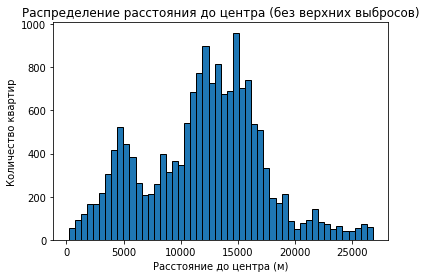

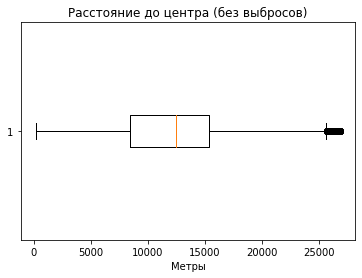

In [ ]:
cl_cityCenters_nearest = data[data['cityCenters_nearest'] <= upper_bound]

plt.hist(cl_cityCenters_nearest['cityCenters_nearest'].dropna(), bins=50, edgecolor='black')
plt.title('Распределение расстояния до центра (без верхних выбросов)')
plt.xlabel('Расстояние до центра (м)')
plt.ylabel('Количество квартир')
plt.show()

plt.boxplot(cl_cityCenters_nearest['cityCenters_nearest'].dropna(), vert=False)
plt.title('Расстояние до центра (без выбросов)')
plt.xlabel('Метры')
plt.show()


После удаления выбросов распределение стало ближе к нормальному. Медиана смещена чуть вправо. БОльшинство квартир находятся на расстонии до 17 000 м.

***Рассмотрим следующие данные 'parks_nearest'***

count    8064.000000
mean      490.830729
std       342.554386
min         1.000000
25%       288.000000
50%       454.500000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


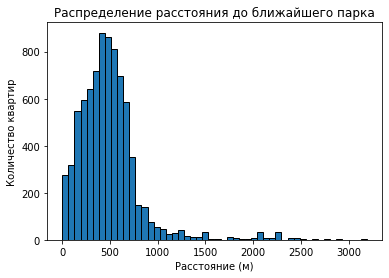

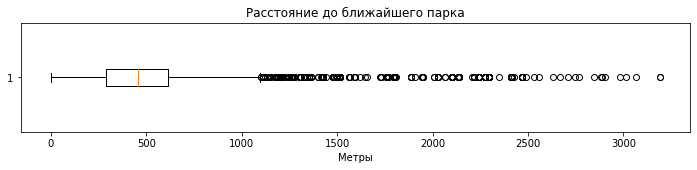

Нижняя граница: -198.0
Верхняя граница: 1098.0


In [ ]:
print(data['parks_nearest'].describe())

plt.hist(data['parks_nearest'].dropna(), bins=50, edgecolor='black')
plt.title('Распределение расстояния до ближайшего парка')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество квартир')
plt.show()

plt.figure(figsize=(12, 2))
plt.boxplot(data['parks_nearest'].dropna(), vert=False)
plt.title('Расстояние до ближайшего парка')
plt.xlabel('Метры')
plt.show()

Q1 = data['parks_nearest'].quantile(0.25)
Q3 = data['parks_nearest'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

Можно отметить, что присутствует выбросы, которые больше 1500 метров. Расстояние нижней границы не может быть отрицательным, поэтому принимаем ее за ноль.

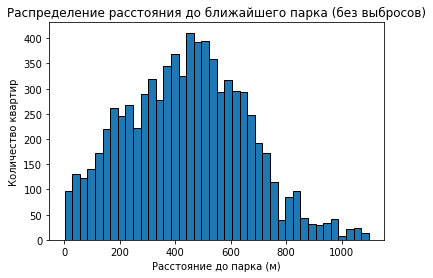

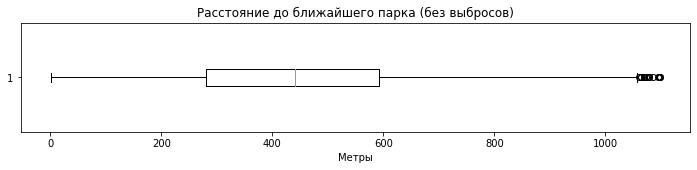

In [ ]:
cl_parks_nearest = data[(data['parks_nearest'] <= upper_bound)]

# Гистограмма
plt.hist(cl_parks_nearest['parks_nearest'].dropna(), bins=40, edgecolor='black')
plt.title('Распределение расстояния до ближайшего парка (без выбросов)')
plt.xlabel('Расстояние до парка (м)')
plt.ylabel('Количество квартир')
plt.show()

# Boxplot
plt.figure(figsize=(12, 2))
plt.boxplot(cl_parks_nearest['parks_nearest'].dropna(), vert=False)
plt.title('Расстояние до ближайшего парка (без выбросов)')
plt.xlabel('Метры')
plt.show()


После удаления выбросов большее количество квартир находится на расстоянии от 250 до 250 метров от парка. Распределение скошено вправо.Медианное расстояние до парка от 800 до 1000 м.

***задание «Изучите, как быстро продавались квартиры (столбец days_exposition)»:
построена гистограмма;
рассчитаны среднее и медиана;
описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.***

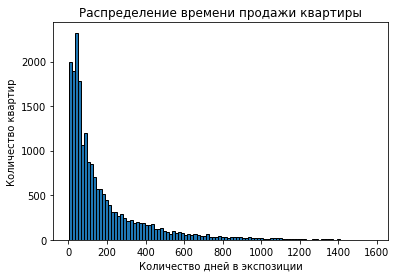

Среднее: 181 дней
Медиана: 95 дней


In [ ]:
plt.hist(data['days_exposition'].dropna(), bins=100, edgecolor='black')
plt.title('Распределение времени продажи квартиры')
plt.xlabel('Количество дней в экспозиции')
plt.ylabel('Количество квартир')
plt.show()

mean_days = data['days_exposition'].mean()
median_days = data['days_exposition'].median()

print(f'Среднее: {round(mean_days)} дней')
print(f'Медиана: {round(median_days)} дней')

Что касается данного параметра. На гитограмме можно отметить, что большее количество квартир было продано за от 0 до 75 дней. Среднее время продаж составляет 181 день, медиана - 95 дней.Исходя из графика можно предложить распределить продажи следующим образом. Быстрые продажи - до 25 дней, максимум до 45 дней()максимум чуть больше месяца). Долгими продажами, опираясь на этот график можем считать от 120 дней дней(более 4 месяцев).

*** Мы должны базово определить какие параметры больше всего влияют на цену квартиры. ***

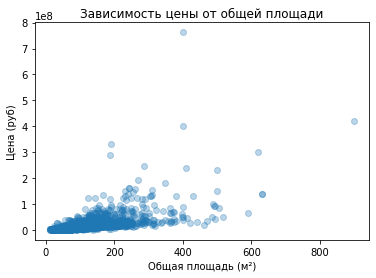

Коэффициент корреляции Пирсона: 0.65


In [ ]:
plt.scatter(data['total_area'], data['last_price'], alpha=0.3)
plt.title('Зависимость цены от общей площади')
plt.xlabel('Общая площадь (м²)')
plt.ylabel('Цена (руб)')
plt.show()

correlation = data['total_area'].corr(data['last_price'], method='pearson')
print(f'Коэффициент корреляции Пирсона: {correlation:.2f}')

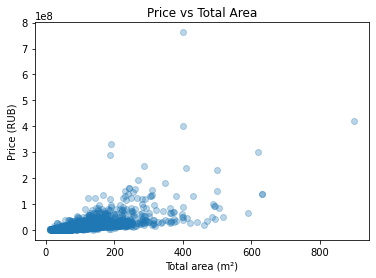

Pearson correlation coefficient: 0.65


In [ ]:
plt.scatter(data['total_area'], data['last_price'], alpha=0.3)
plt.title('Price vs Total Area')
plt.xlabel('Total area (m²)')
plt.ylabel('Price (RUB)')
plt.show()

correlation = data['total_area'].corr(data['last_price'], method='pearson')
print(f'Pearson correlation coefficient: {correlation:.2f}')

Большинство точек находятся внизу слева. Это квартиры малой и средней площади. Можно отметить, что есть положительная зависимости между ценой и площадью. Что касается плотности точек, то она говорит о том, что большинство квартир находится в диапазоне 30-200 м2.
что касается корреляции Пирсона 0.65 говорит об "умеренно сильной положительной линейной зависимости"*

***Соотношение цены и жилой площади***

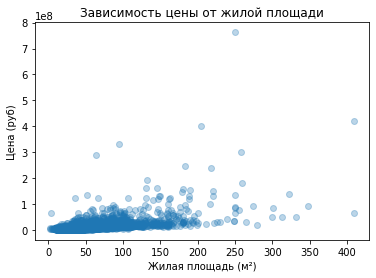

Коэффициент корреляции Пирсона: 0.57


In [ ]:
plt.scatter(data['living_area'], data['last_price'], alpha=0.3)
plt.title('Зависимость цены от жилой площади')
plt.xlabel('Жилая площадь (м²)')
plt.ylabel('Цена (руб)')
plt.show()

correlation = data['living_area'].corr(data['last_price'], method='pearson')
print(f'Коэффициент корреляции Пирсона: {correlation:.2f}')

Много точек находится в левом нижнем углу. Наблюдается тенденция, что чем больше жилая площадь, тем больше цена. Коэффициент корреляции Пирсона составил 0.57, что указывает на среднюю линейную связь между этими параметрами.

***Соотношение цены и жилой площади и размера кухни***

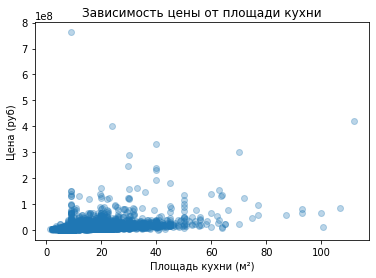

Коэффициент корреляции Пирсона: 0.44


In [ ]:
plt.scatter(data['kitchen_area'], data['last_price'], alpha=0.3)
plt.title('Зависимость цены от площади кухни')
plt.xlabel('Площадь кухни (м²)')
plt.ylabel('Цена (руб)')
plt.show()

correlation = data['kitchen_area'].corr(data['last_price'], method='pearson')
print(f'Коэффициент корреляции Пирсона: {correlation:.2f}')

Большинство также сосредоточено слева снизу в значениях метража от 3 до 18 м2, цены тоже имеют взаимосвязь с метражом кухни, но не сильную.Коэффициент корреляции Пирсона составил 0.44, что указывает на слабую положительную линейную связь.

Соотношение цены и жилой площади и количества комнат. При анализе параметра количество комнат мы отбросили все значения, привышающие количество комнат 6.

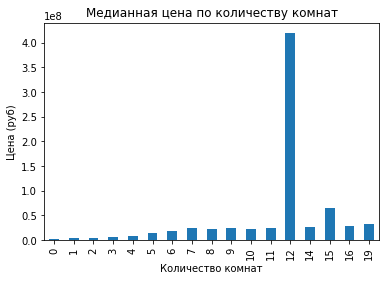

In [ ]:
data.groupby('rooms')['last_price'].median().plot(kind='bar')
plt.title('Медианная цена по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена (руб)')
plt.show()

Цена повышается исходя из увеличением числа комнат, но не линейно. Цена с 0 комнат, скорей всего студия. Они стоят дешевле, чем квартиры с 1, 2 и т.д. Цена меняется, но разброс не слишком большой.

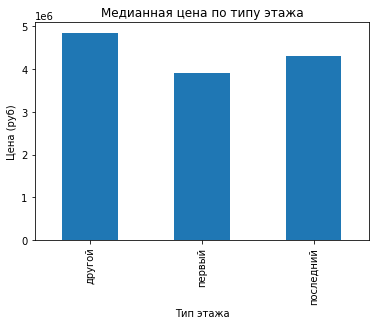

In [ ]:
data.groupby('floor_type')['last_price'].median().plot(kind='bar')
plt.title('Медианная цена по типу этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Цена (руб)')
plt.show()

Квартиры, расположенные на первом этаже значительно дешевле, чем квартиры, рассположенные на других этажах. Также значительно различается цена у квартир на последнем этаже.

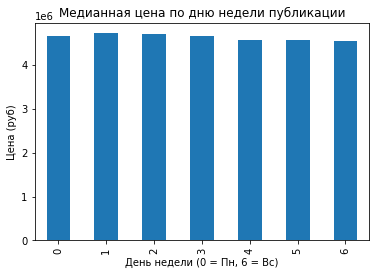

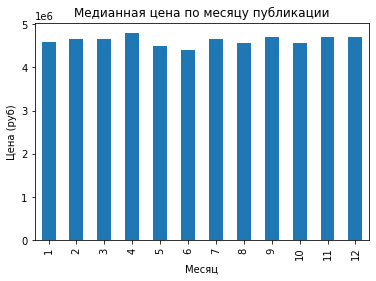

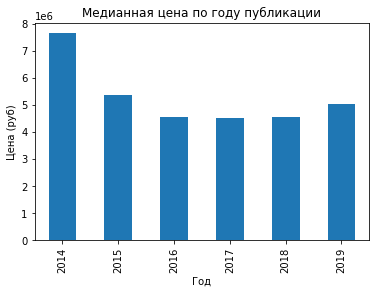

In [ ]:
data.groupby('weekday')['last_price'].median().plot(kind='bar')
plt.title('Медианная цена по дню недели публикации')
plt.xlabel('День недели (0 = Пн, 6 = Вс)')
plt.ylabel('Цена (руб)')
plt.show()


data.groupby('month')['last_price'].median().plot(kind='bar')
plt.title('Медианная цена по месяцу публикации')
plt.xlabel('Месяц')
plt.ylabel('Цена (руб)')
plt.show()


data.groupby('year')['last_price'].median().plot(kind='bar')
plt.title('Медианная цена по году публикации')
plt.xlabel('Год')
plt.ylabel('Цена (руб)')
plt.show()

Можно сказать, что день недели побликации не сильно влияет на цену квартиры, немного ниже цена на квартиры, выложенные в воскресенье. Что касается месяцев наиболее приятные предложения по ценам можно наблюдать  с мая по июне. Также стоит обращать внимание на некую тенденцию снижения цены в августе и октябре. Что касается годов. Наиболее высокая цена за квартиры была в 2014 году. Наиболее низкая цена за квартиры была с 2016 по 2018 год, после чего цена поднялась.

***ВЫВОД***
самый сильный фактор влияния - общая площадь, далее также влияет жилая площадь. Четкую зависимость можно проследить от количество комнат в квартире. Также показательным является этаж, на котором находится квартиры. Дата размещения незначительно, но тоже влияет на ценообразование. РАспределение по годам может быть отражением экономической и социальной ситуации в стране.

In [ ]:
#этот показатль поможет нам понять на сколько дорого стоит каждый кв.м. жилья
data['price_per_sq_meter'] = (data['last_price'] / data['total_area']).round(2)

# считаем для каждого населенного пункта, сколько в нем объявлений и среднюю цену за м2
locality_stats = data.groupby('locality_name').agg({
    'price_per_sq_meter': 'mean',
    'locality_name': 'count'
}).rename(columns={'locality_name': 'ad_count'})

# Берем 10тку
top_10 = locality_stats.sort_values('ad_count', ascending=False).head(10)

# Округлим цену
top_10['price_per_sq_meter'] = top_10['price_per_sq_meter'].round(0)

most_expensive = top_10['price_per_sq_meter'].idxmax()
cheapest = top_10['price_per_sq_meter'].idxmin()

print(f"Самая высокая цена за м²: {most_expensive}")
print(f"Самая низкая цена за м²: {cheapest}")

display(top_10)

Самая высокая цена за м²: санкт-петербург
Самая низкая цена за м²: выборг


,price_per_sq_meter,ad_count
locality_name,,
санкт-петербург,114849.0,15721
мурино,86088.0,590
кудрово,95325.0,472
шушары,78677.0,440
всеволожск,68654.0,398
пушкин,103126.0,369
колпино,75425.0,338
парголово,90176.0,327
гатчина,68746.0,307


Вывод: самая высокая стоимость м2 в Санкт- петербурге
    Самая низкая в г. Выборг

задание «Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите их среднюю стоимость на разном удалении от центра»:
учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
описано, как стоимость объекта зависит от расстояния до центра города;
построен график изменения средней цены для каждого километра от центра Петербурга.

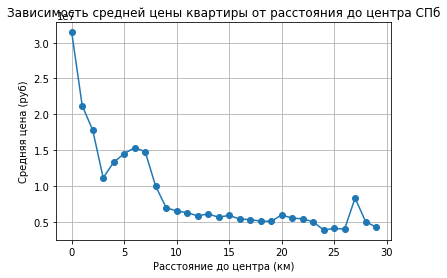

In [ ]:
# Создаём копию только один раз и сразу
spb_data = data[data['locality_name'] == 'санкт-петербург'].copy()

# Добавляем округлённое расстояние до центра в км
spb_data['city_center_km'] = (spb_data['cityCenters_nearest'] / 1000).round()

# Считаем среднюю цену по каждому километру
center_price_by_km = spb_data.groupby('city_center_km')['last_price'].mean().round()

# Строим график
center_price_by_km.plot(kind='line', marker='o')
plt.title('Зависимость средней цены квартиры от расстояния до центра СПб')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя цена (руб)')
plt.grid(True)
plt.show()

Создали копию, чтобы не столкнуться с непредвиженной ошибкой. Для анализа были выбраны квартиры только из Санкт-Петербурга, расстояние мы округлили до километров, чтобы не работать с большими цифрами. Самые высокие цены можно отметить у квартир находящизся в центре города и в 5-7 км. от центра города. Может быть это связано с какими-то жилыми кварталами с улучшеной инфорструктурой. Подобный скачок (но с меньшей суммой) наблюдается с расстоянием от города 27 км.В целом есть общий тренд, что чем дальше от центра города, тем ниже цена на недвижимость.

### Напишите общий вывод

ЧТо касается общих выводов по работе. Нами была проделана большая работа по предобработке данных. Были заполнены проски данных, исправлены аномалии, например в столбце "высота потолка", некоторые форматы были преобразованы. Выбросы были удалены.

Также нами были добавлены новые параметры:  
– цена одного квадратного метра;
 – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
 – месяц публикации объявления;
 – год публикации объявления;
 – тип этажа квартиры (значения — «первый», «последний», «другой»);
 – расстояние до центра города в километрах.

 Следующим шагом было проведение исследовательского анализа, который показал, что общая площадь имеет большое влияние на формирование цены, следующим важным фактором является жилая площадь.
 Стоит отметить, что еще один важным параметром является количеством комнат. нами была подтверждена тенденция, что чем больше комнат, тем больше цена.

 Важным фактором ценообразования является этаж, на котором располагается квартира. Более дешевые квартиры расположены на первом и последнем этаже.

Дата размещения объявления практически не оказывает влияние на формирование цены, однако год продажи влияет на этот показать значительно.

При анализе стоимости м2 было определена тенденция, что чем ближе квартира находится к центру города, тем дороже стоит ее м2. Самый дорогой м2 в культурной столице России - СПБ. Также есть прямая зависимость, что чем ближе квартира находится к центру города, тем дороже стоит ее м2.

Что касается продаж. Нами были проанализированы данные, полученные из имеющейся базы данных, а также проанализироваа информация в интернете о скорости продажи квартир. После чего были сделаны выводы, что быстрые продажи - до 25 дней, максимум до 45 дней()максимум чуть больше месяца). Долгими продажами, опираясь на этот график можем считать от 120 дней дней(более 4 месяцев).

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.